# Canadian Wildfire Data

Author: Jason R. Wang

Last modified: 2019-06-01 (or the latest date shown on my GitHub repo)

See on GitHub: [jasonrwang/AB-Wildfire](https://github.com/jasonrwang/AB-Wildfire)

## Preamble

After doing the analysis in `AB-Wildfire.ipynb` and `BC-Wildfire.ipynb`, [Simon Bridge](https://twitter.com/srjbridge) from the NRCan Canadian Forest Service pointed out on Twitter that I overlooked a dataset from the Canadian Wildfire Info System Datamart, which I had been looking at (and valided data against), actually has data for all provinces from 1950 to 2016. It's listed under 'National Fire Database fire point data' at the [CWFIS site](http://cwfis.cfs.nrcan.gc.ca/datamart). So I'm back again because I'm curious how much each province has contributed over time.

## Reference

Canadian Forest Service. 2017. Canadian National Fire Database – Agency Fire Data. Natural Resources Canada, Canadian Forest Service, Northern Forestry Centre, Edmonton, Alberta. http://cwfis.cfs.nrcan.gc.ca/ha/nfdb

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/CA/NFDB_point_20181129_large_fires.txt', encoding='latin-1')

In [3]:
df.columns

Index(['FID_', 'SRC_AGENCY', 'FIRE_ID', 'FIRENAME', 'LATITUDE', 'LONGITUDE',
       'YEAR_', 'MONTH_', 'DAY_', 'REP_DATE', 'ATTK_DATE', 'OUT_DATE',
       'DECADE', 'SIZE_HA', 'CAUSE', 'PROTZONE', 'FIRE_TYPE', 'MORE_INFO',
       'CFS_REF_ID', 'CFS_NOTE1', 'CFS_NOTE2', 'ACQ_DATE'],
      dtype='object')

In [60]:
dfYear = df.groupby(by=['YEAR_', 'SRC_AGENCY']).sum().reset_index()
dfYear = dfYear[dfYear['YEAR_'] != -999]

In [61]:
# Where the year is -999, the year is unknown.
# I'm going to distribute those attributes uniformly across the listed decade.

# These total to 70,000 ha, so I'm going to ignore them for now

# for row in df[df['YEAR_'] == -999]:
#     print(row)

In [286]:
newest = dfYear.groupby(by='SRC_AGENCY')['YEAR_'].max().max()
oldest = dfYear.groupby(by='SRC_AGENCY')['YEAR_'].min().min()
yr_range = range(oldest, newest+1, 1) # newest+1 because upper bound is non-inclusive
agencies = dfYear['SRC_AGENCY'].sort_values().unique()

This database categorizes national parks separately from provinces. While this might make sense for bureaucratic reasons, I'd rather combine them. Most of the mappings are given in the accompanying metadata file, but I had to assume that `NL-LAB` is the same as `NL` (Newfoundland) and `PC-NC` is still in the Northwest Territories (I didn't bother to look up the Lat/Lon coordinates).

In [287]:
df[df['SRC_AGENCY'] == 'PC-NC']

,FID_,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR_,MONTH_,DAY_,REP_DATE,...,DECADE,SIZE_HA,CAUSE,PROTZONE,FIRE_TYPE,MORE_INFO,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,ACQ_DATE
16362,NaN,PC-NC,2015NC1,Little Nahanni,62.538,-128.855,2015,0,0,2015-05-29 0:00:00,...,2010-2019,200.0,L,Modified Response,,,PC-NC-2015-2015NC1,,Note that src coordinates outside Park/agency ...,2016-06-20 0:00:00


In [288]:
PC_mapping =    {
    'AB': ['PC-BA','PC-EI','PC-JA','PC-WB','PC-WL'],
    'BC': ['PC-KO','PC-GL','PC-RE','PC-YO'],
    'MB': ['PC-RM','PC-WP'],
    'NB': [],
    'NL': ['NL-LAB','PC-TN'], 
    'NS' :['PC-KE',],
    'NWT': ['PC-NA','PC-NC'],
    'ON': ['PC-PU'],
    'QC': ['PC-LM'],
    'SK': ['PC-GR', 'PC-PA'],
    'YT': ['PC-VU']
}

In [372]:
df_full = pd.DataFrame(columns = ['Agency', 'Year', 'Area'])

for agency in agencies:
    for year in yr_range:
        area = dfYear[(dfYear['SRC_AGENCY'] == agency) & (dfYear['YEAR_'] == year)]['SIZE_HA'].values.size # 0 or 1
        if (area):
            df_append = pd.DataFrame.from_dict({'Agency': [agency],'Year': [year],
                 'Area': dfYear[(dfYear['SRC_AGENCY'] == agency) & (dfYear['YEAR_'] == year)]['SIZE_HA'].values}
                                    )
        else:
            df_append = pd.DataFrame.from_dict({'Agency': [agency],'Year': [year], 'Area': [0]})
        
        # Remap national parks to respective provicne (thank goodness no Canadian national parks cross borders)
        for keys, values in PC_mapping.items():
            if(agency in values): df_append['Agency'] = keys
            
        df_full = df_full.append(df_append)
        
# Finally, clean df_full by aggregating by year        
df_full = df_full.groupby(by=['Agency','Year']).sum().reset_index()

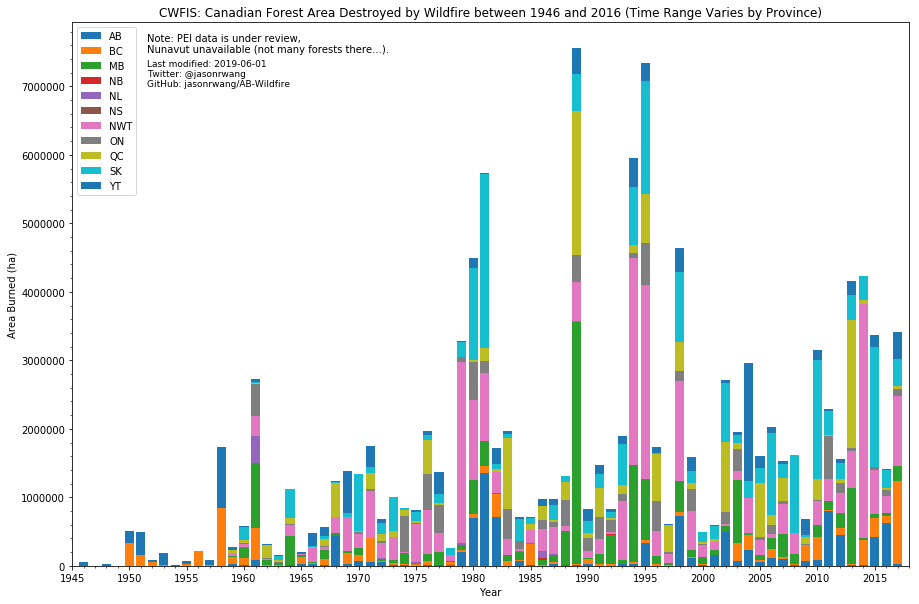

In [411]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

# Our old list `agencies` still has national parks in them. Let's take them out.
agencies = df_full['Agency'].unique()
bottom = pd.Series(0, yr_range)

for agency in agencies:
    df_agency = df_full[df_full['Agency'] == agency]
    plt.bar(df_agency['Year'].values, df_agency['Area'].values, label=agency, bottom=bottom)
    bottom += df_agency['Area'].values
    
ax.set(xlabel = 'Year',
       ylabel='Area Burned (ha)',
       title = 'CWFIS: Canadian Forest Area Destroyed by Wildfire between 1946 and 2016 (Time Range Varies by Province)')
ax.legend(loc = 'upper left')

ax.set_xticks(range(1945, 2021, 5))
plt.minorticks_on()
ax.set_xlim([1945, 2018])

credit = 'Last modified: 2019-06-01\nTwitter: @jasonrwang\nGitHub: jasonrwang/AB-Wildfire'
plt.text(1951.5, 7000000, credit, fontsize=9, horizontalalignment='left')
plt.text(1951.5, 7500000, 'Note: PEI data is under review,\nNunavut unavailable (not many forests there...).',
         fontsize=10, horizontalalignment='left')

# # Save the the figure for other uses
plt.savefig('img/CADWildfires_1946-2016.png')
plt.show()

For verification, let's compare it to our original dataset.

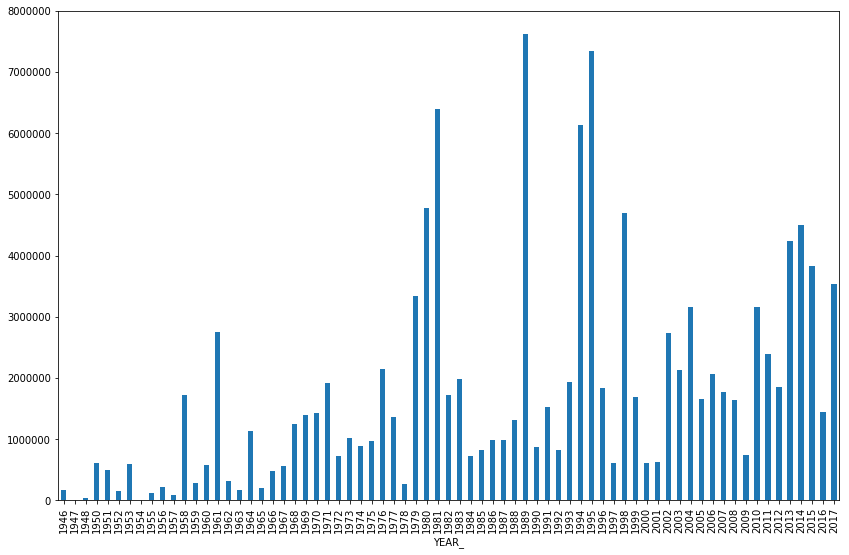

In [412]:
dfYear.groupby(by='YEAR_').sum()['SIZE_HA'].plot.bar(figsize=(14,9))
plt.show()

Looks good now. However, that's after a few hours of cleaning ;)

To determine _contribution_, we should also normalize this forest fire data by the actual forest area in each province.

Do we have that data? If not, we can use actual area.